In [1]:
import cv2
import os
import sys
import numpy as np
import pandas as pd
from PIL import Image
import argparse
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from original.entity import params, JointType
from badminton_pose_detector import PoseDetector, draw_person_pose

In [2]:
def select_region(image):
    if len(image.shape) == 3:
        high, wid, ch = image.shape
    else:
        high, wid = image.shape

    # make area
    bottom_left  = [wid*0.1, high*1]
    top_left     = [wid*0.30, high*0.3]
    bottom_right = [wid*0.9, high*1]
    top_right    = [wid*0.7, high*0.3]
    # polygons 
    poly = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, poly, 255)
    else:
        # in case of channel=3
        cv2.fillPoly(mask, poly, (255,)*mask.shape[2])

    return cv2.bitwise_and(image, mask), mask

In [3]:
#load model
pose_detector = PoseDetector("posenet", "../models/coco_posenet.npz", device=0, precise=True)
print("load model done!")

Loading the model...
load model done!


In [4]:
def compute_limbs_length(joints): # limbs_len is something wrong
    limbs = []
    limbs_len = np.zeros(len(params["limbs_point"])) # 19 points
    for i, joint_indices in enumerate(params["limbs_point"]):
        if joints[joint_indices[0]] is not None and joints[joint_indices[1]] is not None: # 鼻or首があるか確認する
            limbs.append([joints[joint_indices[0]], joints[joint_indices[1]]])
            limbs_len[i] = np.linalg.norm(joints[joint_indices[1]][:-1] - joints[joint_indices[0]][:-1])
        else:
            limbs.append(None)

    return limbs_len, limbs

def compute_unit_length(limbs_len): # 鼻首の長さを優先しない
    unit_length = 0
    base_limbs_len = limbs_len[[3, 0, 13, 9]] # (首左腰、首右腰、肩左耳、肩右耳)の長さの比率(このどれかが存在すればこれを優先的に単位長さの計算する)
    non_zero_limbs_len = base_limbs_len > 0
    if len(np.nonzero(non_zero_limbs_len)[0]) > 0:
        limbs_len_ratio = np.array([2.2, 2.2, 0.85, 0.85])
        unit_length = np.sum(base_limbs_len[non_zero_limbs_len] / limbs_len_ratio[non_zero_limbs_len]) / len(np.nonzero(non_zero_limbs_len)[0])
    else:
        limbs_len_ratio = np.array([2.2, 1.7, 1.7, 2.2, 1.7, 1.7, 0.6, 0.93, 0.65, 0.85, 0.6, 0.93, 0.65, 0.85, 1, 0.2, 0.2, 0.25, 0.25]) # 鼻首を1としている
        non_zero_limbs_len = limbs_len > 0
        unit_length = np.sum(limbs_len[non_zero_limbs_len] / limbs_len_ratio[non_zero_limbs_len]) / len(np.nonzero(non_zero_limbs_len)[0])

    return unit_length

def get_unit_length(person_pose):
    limbs_length, limbs = compute_limbs_length(person_pose)
    unit_length = compute_unit_length(limbs_length)

    return unit_length, limbs_length


In [5]:
# define crop person
def crop_person(img, person_pose, unit_length):
    top_joint_priority = [4, 5, 6, 12, 16, 7, 13, 17, 8, 10, 14, 9, 11, 15, 2, 3, 0, 1, sys.maxsize]
    bottom_joint_priority = [9, 6, 7, 14, 16, 8, 15, 17, 4, 2, 0, 5, 3, 1, 10, 11, 12, 13, sys.maxsize]

    top_joint_index = len(top_joint_priority) - 1
    bottom_joint_index = len(bottom_joint_priority) - 1
    left_joint_index = 0
    right_joint_index = 0
    top_pos = sys.maxsize
    bottom_pos = 0
    left_pos = sys.maxsize
    right_pos = 0

    for i, joint in enumerate(person_pose):
        if joint[2] > 0:
            if top_joint_priority[i] < top_joint_priority[top_joint_index]:
                top_joint_index = i
            elif bottom_joint_priority[i] < bottom_joint_priority[bottom_joint_index]:
                bottom_joint_index = i
            if joint[1] < top_pos:
                top_pos = joint[1]
            elif joint[1] > bottom_pos:
                bottom_pos = joint[1]

            if joint[0] < left_pos:
                left_pos = joint[0]
                left_joint_index = i
            elif joint[0] > right_pos:
                right_pos = joint[0]
                right_joint_index = i

    top_padding_ratio = [0.9, 1.9, 1.9, 2.9, 3.7, 1.9, 2.9, 3.7, 4.0, 5.5, 7.0, 4.0, 5.5, 7.0, 0.7, 0.8, 0.7, 0.8]
    bottom_padding_ratio = [6.9, 5.9, 5.9, 4.9, 4.1, 5.9, 4.9, 4.1, 3.8, 2.3, 0.8, 3.8, 2.3, 0.8, 7.1, 7.0, 7.1, 7.0]

    left = (left_pos - 0.3 * unit_length).astype(int)
    right = (right_pos + 0.3 * unit_length).astype(int)
    top = (top_pos - top_padding_ratio[top_joint_index] * unit_length).astype(int)
    bottom = (bottom_pos + bottom_padding_ratio[bottom_joint_index] * unit_length).astype(int)
    bbox = (left, top, right, bottom)

    cropped_img = pose_detector.crop_image(img, bbox)
    return cropped_img, bbox

## Flow-based Pose Track 実装
The flow-based inference algorithm for video human pose tracking
![](https://i.imgur.com/pWWqoUY.png)
前フレームのbboxを保持して比較したときに大きく変化した場合に処理を変える

In [6]:
# 矩形内の面積を求める
def get_bbox_area(bbox):
    width = abs(bbox[0] - bbox[2])
    hight = abs(bbox[1] - bbox[3])
    area = width * hight
    return area

# 矩形内の重心座標を取得する
def get_centerof_bbox(bbox): # should be (x,y)
    left_top = np.array([bbox[0], bbox[1]])
    right_bottom = np.array([bbox[2], bbox[3]])
    center_point = (left_top + right_bottom)//2
    return center_point

# 選手の位置は合っているが矩形の大きさがおかしいので、今のフレームの重心を中心にして前フレームのbboxの大きさを切り取る
def get_new_bbox(current_bbox_center, previous_bbox):
    new_bbox = np.copy(previous_bbox)
    half_width = abs(previous_bbox[0] - previous_bbox[2])/2*1.2
    half_hight = abs(previous_bbox[1] - previous_bbox[3])/2*1.2
    new_bbox[0] = current_bbox_center[0] - half_width
    new_bbox[1] = current_bbox_center[1] - half_hight
    new_bbox[2] = current_bbox_center[0] + half_width
    new_bbox[3] = current_bbox_center[1] + half_hight
    return new_bbox

In [26]:
imgs_dir = pd.read_csv('../feature_images.txt', sep=',', usecols=[1,2])


In [40]:
ave_pose = np.average(multi_poses[:], axis=1)
multi_person_poses = multi_poses[np.argsort(ave_pose[:,1])[::-1]]

In [24]:
# for 文でループ回す、一つ前のフレームを保持する
previous_bbox = 0
for i, img_name in enumerate(imgs_dir["Img_name"]):
    img = cv2.imread('../../Annotations/youtube/baun/{}'.format(img_name))
    play_region_img, mask = select_region(img)
    multi_poses, scores = pose_detector(play_region_img)
    # 全パーツの平均の座標でポーズをソートする ⇨ 0:bottom, 1:top player
    ave_pose = np.average(multi_poses[:], axis=1)
    multi_person_poses = multi_poses[np.argsort(ave_pose[:,1])[::-1]]
    
    # 0:bottom, 1:top player
    pose_num = 0
    # pose_numが変わってもディレクトリは変わらないようにするため
    player_dir = pose_num
    
    unit, limb_length = get_unit_length(multi_person_poses[pose_num])
    cropped_img, bbox = crop_person(img, multi_person_poses[pose_num], unit)
    
    # 最初のループは飛ばす, initializer
    if i == 0:
        print('Skipped first roop')
        previous_bbox = list(bbox)
        cv2.imwrite('../data/{0}/{1}'.format(player_dir, img_name), cropped_img)
        previous_bbox_center = get_centerof_bbox(bbox)
        continue
        
    # 前フレームのbboxの座標と比較して離れすぎていたら前のフレームのbboxを利用する
    current_bbox_center = get_centerof_bbox(bbox)
    diffence = np.abs(previous_bbox_center - current_bbox_center)
    diffence_length = np.linalg.norm(diffence)
    bbox_width = abs(bbox[0] - bbox[2])
    
    # 選手位置がずれていないか
    if (diffence_length > bbox_width): # 選手位置が大きくずれている
        print('Detected different player: {}'.format(img_name))
        # ---------ここで違う姿勢を検出してしまったときの処理必要---------
        if pose_num == 0:
            pose_num += 1
        else:
            pose_num -= 1
        unit, limb_length = get_unit_length(multi_person_poses[pose_num])
        cropped_img, bbox = crop_person(img, multi_person_poses[pose_num], unit)
        current_bbox_center = get_centerof_bbox(bbox)
        new_bbox = get_new_bbox(current_bbox_center, previous_bbox)
        cropped_img = pose_detector.crop_image(img, new_bbox)
        
    else: # 選手位置がずれていない
        # 矩形の面積を求める
        previous_bbox_area = get_bbox_area(previous_bbox)
        current_bbox_area = get_bbox_area(bbox)
        # 選手の位置がずれていなかったら重心の更新
        previous_bbox_center = np.copy(current_bbox_center)
        # 大きさには対応しているかどうか
        if (current_bbox_area > previous_bbox_area*2): # bboxが大きすぎる
            # 前フレームのbboxと比較して大きすぎたら、今のフレームの重心を中心に前フレームと同じ大きさのbboxを使う
            new_bbox = get_new_bbox(current_bbox_center, previous_bbox)
            cropped_img = pose_detector.crop_image(img, new_bbox)
            print('Bbox was too big in the image: {}'.format(img_name))
        else: # bboxが正しい大きさ
            # bboxの位置を更新する
            previous_bbox = bbox
            
    cv2.imwrite('../data/{0}/{1}'.format(player_dir, img_name), cropped_img)

print('Done!')

Skipped first roop
Bbox was too big in the image: img_08335.png
Bbox was too big in the image: img_08336.png
Bbox was too big in the image: img_08337.png
Bbox was too big in the image: img_08338.png
Bbox was too big in the image: img_08339.png
Bbox was too big in the image: img_08340.png
Bbox was too big in the image: img_08341.png
Bbox was too big in the image: img_08342.png
Bbox was too big in the image: img_08343.png
Bbox was too big in the image: img_08344.png
Bbox was too big in the image: img_08345.png
Bbox was too big in the image: img_08346.png
Bbox was too big in the image: img_08347.png
Bbox was too big in the image: img_08349.png
Bbox was too big in the image: img_08350.png
Bbox was too big in the image: img_08351.png
Bbox was too big in the image: img_08352.png
Bbox was too big in the image: img_08353.png
Bbox was too big in the image: img_08354.png
Bbox was too big in the image: img_08355.png
Bbox was too big in the image: img_08356.png
Bbox was too big in the image: img_0

ValueError: negative dimensions are not allowed

## プレー画面以外でエラーを起こすため、アノテーションされた時間内だけで選手を切り出す

In [25]:
original_anno = pd.read_csv('../../Annotations/fine_anno_txt/Baun-Augustyn-GrpG-LondonOlympics-2012.txt', sep=',', delimiter='\t', header=None, usecols=[2,3,5], names=["start", "end", "label"])
original_anno.tail()

,start,end,label
843,1791500,1792073,lbpt
844,1792073,1792473,rtpb
845,1792473,1792879,bhpb
846,1792879,1793714,rtpt
847,1793714,1795152,n


In [19]:
len(original_anno)

848

In [24]:
330800/25/60

220.53333333333333

In [53]:
import os
img_list = os.listdir('../data/0/')
img_lists = np.sort(img_list)
for i, img in enumerate(img_lists):
    print('{0}times, {1}'.format(i, img))

0times, .ipynb_checkpoints
1times, img_08290.png
2times, img_08291.png
3times, img_08292.png
4times, img_08293.png
5times, img_08294.png
6times, img_08295.png
7times, img_08296.png
8times, img_08297.png
9times, img_08298.png
10times, img_08299.png
11times, img_08300.png
12times, img_08301.png
13times, img_08302.png
14times, img_08303.png
15times, img_08304.png
16times, img_08305.png
17times, img_08306.png
18times, img_08307.png
19times, img_08308.png
20times, img_08309.png
21times, img_08310.png
22times, img_08311.png
23times, img_08312.png
24times, img_08313.png
25times, img_08314.png
26times, img_08315.png
27times, img_08316.png
28times, img_08317.png
29times, img_08318.png
30times, img_08319.png
31times, img_08320.png
32times, img_08321.png
33times, img_08322.png
34times, img_08323.png
35times, img_08324.png
36times, img_08325.png
37times, img_08326.png
38times, img_08327.png
39times, img_08328.png
40times, img_08329.png
41times, img_08330.png
42times, img_08331.png
43times, img_083

## 姿勢の並び替え
poseの配列をy座標で並び替えてbottom playerとtop playerで分割する

In [33]:
poses[:, 10, 1]

array([ 586.,  817.,  455.,  442.,    0.])

In [32]:
np.sort(poses[:, 10, 1])[::-1]

array([ 817.,  586.,  455.,  442.,    0.])

# Single image for test. 
## poses, score = pose_detector(img)

5


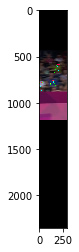

In [12]:
# read image
img = Image.open('../../Annotations/youtube/baun/img_08404.png')
img = np.array(img)
# select detection area
img, mask = select_region(img)
# inference
poses, scores = pose_detector(img) # posesはscoreが高い順
img = draw_person_pose(img, poses)

unit, limb_length = get_unit_length(poses[0])
cropped_img, bbox = crop_person(img, poses[0], unit)
print(len(poses))
# new_bbox = get_new_bbox(current_bbox_center, previous_bbox)
cropped_img = pose_detector.crop_image(img, bbox)
plt.imshow(cropped_img)

## 審判の顔を検出してしまっている..

## poses

25.7508565256


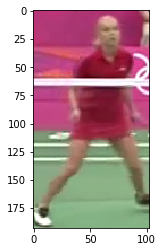

In [23]:
# detect bottom player(0:bottom, 1:top player)
unit_0, limbs_len = get_unit_length(poses[0])
print(unit_0)
cropped_img_b, bbox_b = crop_person(img, poses[0], unit_0) 
if cropped_img_b is not None:
    crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
    plt.imshow(crop_img_b)

## poses, scores = pose_detector.detect_precise(img_pre)
## poses_pre

[[ 893.  436.    2.]
 [ 886.  457.    2.]
 [ 870.  458.    2.]
 [ 858.  480.    2.]
 [ 863.  498.    2.]
 [ 903.  455.    2.]
 [ 905.  481.    2.]
 [ 909.  499.    2.]
 [ 871.  508.    2.]
 [ 858.  551.    2.]
 [ 832.  586.    2.]
 [ 896.  508.    2.]
 [ 911.  544.    2.]
 [ 918.  576.    2.]
 [ 888.  433.    2.]
 [ 895.  432.    2.]
 [ 881.  436.    2.]
 [ 898.  435.    2.]]


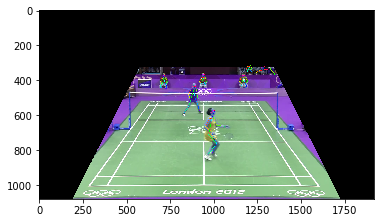

In [79]:
img_pre = cv2.imread('../data/youtube/img_08339.png')
img_pre, mask = select_region(img_pre)

# res_img = cv2.addWeighted(img, 0.6, draw_person_pose(img, poses), 0.4, 0)
# draw keypoint
poses_pre, scores = pose_detector.detect_precise(img_pre) # posesはscoreが高い順
img_pre = draw_person_pose(img_pre, poses_pre)

plt.imshow(img_pre)
print(poses_pre[0])

377.484268333
[   95.35197953    67.35725648    82.61961026    91.04943712    60.8276253
    59.94163828    12.04159458    51.88448708    48.27007354    36.40054945
    11.04536102    46.5188134     43.28972164  1175.02723373    45.69463864
     7.28010989     7.61577311    16.40121947  1152.53156139]


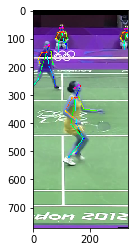

In [85]:
# detect bottom player(0:bottom, 1:top player)
unit_pre_0, limbs_len_pre = get_unit_length(poses_pre[1])
print(unit_pre_0)
print(limbs_len_pre)
cropped_img, bbox = crop_person(img_pre, poses_pre[1], unit_pre_0) 
if cropped_img is not None:
    crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
    plt.imshow(crop_img)

# multi images

In [15]:
# read multi images
for i in range(0,61):    
    print('83{0:02d}'.format(i))
    # read image
    img = cv2.imread('../data/youtube/img_083{0:02d}.png'.format(i))
    # select detection area
    img, mask = select_region(img)
    # inference
    poses, scores = pose_detector(img) # posesはscoreが高い順
    # draw keypoint
    img = draw_person_pose(img, poses)
    # plt.imshow(img)
    
    # compare unit_length 
    unit_0 = get_unit_length(poses[0])
    unit_1 = get_unit_length(poses[1])
    print(unit_1)
    if (unit_1 > 100):
        print(i)
        break
    # detect bottom player(0:bottom, 1:top player)
    cropped_img_b, bbox_b = crop_person(img, poses[0], unit_0) 
    if cropped_img_b is not None:
        crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
        cv2.imwrite('../data/0/crop_{:d}.png'.format(i), crop_img_b)

    # detect top player
    cropped_img, bbox = crop_person(img, poses[1], unit_1) 
    if cropped_img is not None:
        crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
        cv2.imwrite('../data/1/crop_{:d}.png'.format(i), crop_img)

8300
23.1604041602
8301
22.8886976893
8302
22.7768242437
8303
23.3837262799
8304
23.0123025444
8305
23.8046210198
8306
23.8102025666
8307
24.1815382659
8308
23.3440314045
8309
23.6728515044
8310
23.9763472108
8311
24.8892989568
8312
24.5155856087
8313
24.0412436339
8314
24.1446919293
8315
23.448303899
8316
22.7705782326
8317
22.985473912
8318
22.2795599226
8319
23.0119738999
8320
22.9951745644
8321
23.410459384
8322
22.2508998772
8323
24.3489835384
8324
24.8253212601
8325
24.0743849765
8326
24.7657991346
8327
25.1410389542
8328
26.3954220573
8329
27.2214471172
8330
27.2774241212
8331
26.1193110958
8332
25.3058630592
8333
25.6212625673
8334
25.2575851421
8335
26.1699147211
8336
25.4435723141
8337
24.8241934983
8338
24.8139654057
8339
377.484268333


In [ ]:
if (unit_0 > unit_1): # (larger=bottom)
        # detect bottom player(0:bottom, 1:top player)
        cropped_img_b, bbox_b = pose_detector.crop_person(img, poses[0], unit_0) 
        if cropped_img_b is not None:
            crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
            cv2.imwrite('./data/0/crop_{:d}.png'.format(i), crop_img_b)
        
        # detect top player
        cropped_img, bbox = pose_detector.crop_person(img, poses[1], unit_1) 
        if cropped_img is not None:
            crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
            cv2.imwrite('./data/1/crop_{:d}.png'.format(i), crop_img)
    else:
        print('detect bottom player failed.')    


In [ ]:
# detect bottom player(0:bottom, 1:top player)
cropped_img_b, bbox_b = pose_detector.crop_person(img, poses[0], unit_0) 
if cropped_img_b is not None:
    crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
    cv2.imwrite('./data/0/crop_{:d}.png'.format(i), crop_img_b)

# detect top player
cropped_img, bbox = pose_detector.crop_person(img, poses[1], unit_1) 
if cropped_img is not None:
    crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
    cv2.imwrite('./data/1/crop_{:d}.png'.format(i), crop_img)